This notebook demonstrates how to query the STAC API and return an xarray. The query returns a large number of images within a time window, and these are used to create a GIF which shows activity at a mining site (LEFR3)

In [1]:
import shapely.geometry
from IPython.display import display
from pystac_client import Client
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import geopandas as gpd
from PIL import Image, ImageDraw, ImageFont
import os
from glob import glob
from odc.stac import configure_rio, stac_load
import requests
import json
import re
import pandas as pd
from dotenv import load_dotenv
import boto3
import io
from urllib.parse import urlparse
import seaborn as sns
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'

In [2]:
# Uncomment to run dask cluster
# import dask.distributed

# client = dask.distributed.Client()
# configure_rio(cloud_defaults=True, aws={"aws_unsigned": True}, client=client)
# display(client)

Authenticate with the STAC API, if you get an error check your credentials in `.env`

In [3]:
load_dotenv()  # take environment variables from .env.

def get_new_token():
    auth_server_url = os.getenv("EDS_AUTH_URL")
    client_id = os.getenv("EDS_CLIENT_ID")
    client_secret = os.getenv("EDS_SECRET")
    token_req_payload = {'grant_type': 'client_credentials'}

    token_response = requests.post(
        auth_server_url,
        data=token_req_payload,
        verify=False,
        allow_redirects=False,
        auth=(client_id, client_secret)
    )
    token_response.raise_for_status()

    tokens = json.loads(token_response.text)
    return tokens['access_token']

token = get_new_token()

catalog = Client.open(os.getenv("EDS_API_URL"), headers={
    "Authorization": f"bearer {token}"
})

/home/codespace/.local/lib/python3.10/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host 'core-earthdaily.auth.us-east-1.amazoncognito.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


# Now select mission & catalogue
Edit the cell below to select between "S2" or "VENUS"

In [4]:
SATELLITE = "VENUS" # "S2" or "VENUS"

if SATELLITE == "S2":
    COLLECTION = "sentinel-s2-l2a"
    BANDS = ("B04", "B03", "B02")

elif SATELLITE == "VENUS":
    COLLECTION = "venus-l2a"
    BANDS = ("red", "green", "blue", ) # "nir08", "rededge", "yellow", "coastal"

Setup location to save generated data

In [5]:
SITE = "LEFR3" # site name in this tutorial

OUTPUTS_DIR = f"outputs_{SITE}_{SATELLITE}/" # location where the output files will be saved
if not os.path.exists(OUTPUTS_DIR):
    os.makedirs(OUTPUTS_DIR)

EMPTY_OUTPUTS_DIR = True # set to True to delete all files in OUTPUTS_DIR before running the notebook
if EMPTY_OUTPUTS_DIR:
    for f in glob(OUTPUTS_DIR + "*"):
        os.remove(f)

print(f"Using {SATELLITE} data from {catalog.description}")
print(f"Writing outputs to {OUTPUTS_DIR}")

Using VENUS data from stac-fastapi
Writing outputs to outputs_LEFR3_VENUS/


### Leafmap
This method requires having the URL for one of the COGS - get the url for the B1 band from the EDA catalogue

- Not displaying for some reason

In [6]:
import leafmap

Map = leafmap.Map()
image_file_FRE_B1 = "s3://venus-l2a-cogs/LEFR3/2020/10/08/VENUS-XS_20201008-020631-000_L2A_LEFR3_D/VENUS-XS_20201008-020631-000_L2A_LEFR3_C_V3-0_FRE_B1.tif"

Map.add_cog_layer(image_file_FRE_B1, name=SITE)

Map

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

Draw an ROI on the map above or use the default

In [8]:
ROI = Map.user_roi
if not ROI:
    print("Did not draw a polygon using the rectangle tool, using default")

    ROI = {'type': 'Feature',
 'properties': {},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[121.735811, -31.309868],
    [121.735811, -31.293184],
    [121.763749, -31.293184],
    [121.763749, -31.309868],
    [121.735811, -31.309868]]]}}

ROI

Did not draw a polygon using the rectangle tool, using default


{'type': 'Feature',
 'properties': {},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[121.735811, -31.309868],
    [121.735811, -31.293184],
    [121.763749, -31.293184],
    [121.763749, -31.309868],
    [121.735811, -31.309868]]]}}

In [10]:
def get_bounds_polygon_dict(polygon_dict: dict) -> tuple:
    gdf = gpd.GeoDataFrame.from_features([polygon_dict])
    polygon = gdf.geometry.iloc[0]
    bounds = polygon.bounds
    return bounds

bbox = get_bounds_polygon_dict(ROI)
print(bbox)

(121.735811, -31.309868, 121.763749, -31.293184)


## STAC query
Set your remaining filter parameters and perform the query

In [11]:
# Set a start and end date
start_date = "2015-01-01"
end_date = "2023-06-01"
max_clouds = 30 # the maximum cloud cover percentage. Note this is over the WHOLE image, not just the ROI

query = catalog.search(
    collections=[COLLECTION], 
    datetime=f"{start_date}/{end_date}",
    bbox=bbox,
    query={"eo:cloud_cover":{"lt":max_clouds}},
)

items = list(query.get_items())
print(f"Found: {len(items):d} datasets")

Found: 195 datasets


Get timerange of dataset

In [12]:
all_dt = []
for item in items:
    dt = item.to_dict()['properties']['datetime']
    dt = pd.to_datetime(dt) # .strftime("%Y-%m-%d-%H-%M-%S")
    all_dt.append(dt)

all_dt = sorted(all_dt)
min_date = min(all_dt)
max_date = max(all_dt)

min_date_str = min_date.strftime("%Y-%m-%d %H:%M:%S")
max_date_str = max_date.strftime("%Y-%m-%d %H:%M:%S")
date_range = f"{min_date_str} to {max_date_str}"
print(date_range)

time_window = max_date - min_date
print(f"Time window: {time_window}")

2017-11-29 02:10:59 to 2020-10-20 02:06:06
Time window: 1055 days 23:55:07


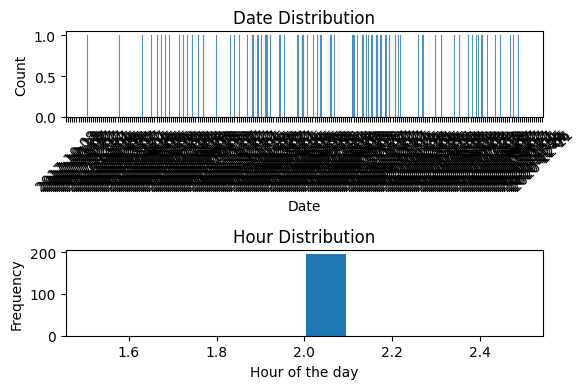

In [13]:
# Create a DataFrame
df = pd.DataFrame(all_dt, columns=['Datetime'])

# Extract date and time
df['Date'] = df['Datetime'].dt.date
df['Time'] = df['Datetime'].dt.time

fig, ax = plt.subplots(2, 1, figsize=(6, 4))

# Date distribution (Histogram)
sns.histplot(df['Date'], ax=ax[0])
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax[0].xaxis.set_major_locator(mdates.DayLocator(interval=5))  # adjust as needed
plt.setp(ax[0].xaxis.get_majorticklabels(), rotation=45)
ax[0].set_title('Date Distribution')

# Time distribution (Histogram)
df['Time'].apply(lambda x: x.hour).plot(kind='hist', rwidth=0.9, ax=ax[1])
ax[1].set_title('Hour Distribution')
ax[1].set_xlabel('Hour of the day')

plt.tight_layout()
plt.show()

We now use `stac_load` to retrieve an [xarray](https://docs.xarray.dev/en/stable/) dataset using the `items` returned by the STAC query

In [14]:
dataset = stac_load(
    items,
    bands=("red", "green", "blue"),
    crs="epsg:3857", # since resolution is in metres, we need to use a projected CRS
    resolution=5, # the reoslution of the output image in metres
    # chunks={},  # Uncomment if using dask cluster
    groupby="id",
    bbox=bbox,
)

display(dataset)

Aborting load due to failure while reading: s3://venus-l2a-cogs/LEFR3/2020/10/20/VENUS-XS_20201020-020606-000_L2A_LEFR3_D/VENUS-XS_20201020-020606-000_L2A_LEFR3_C_V3-0_FRE_B7.tif:1


RasterioIOError: AWS_SECRET_ACCESS_KEY and AWS_NO_SIGN_REQUEST configuration options not defined, and /home/codespace/.aws/credentials not filled

Data is loaded lazily if using Dask - call `.compute()` to load the data, this can take minutes if there are many images to load or the bbox is large

In [ ]:
# dataset = dataset.compute()

Let's create an RGB image for each timestamp in the `dataset` using [Pillow](https://pillow.readthedocs.io/en/stable/)

Each image is written to the `OUTPUTS_DIR`

Note that conversion to uint8 will quantize the data in order to reduce the filesize

In [ ]:
%%time
def normalise_img(x):
    "Scale pixel values to 0-1 range"
    return x / x.max()

for i in range(len(dataset.time)):
    ds = dataset.isel(time=i)
    dataarray = ds.to_array("band")
    date = dataarray.time.values
    date = pd.to_datetime(date).strftime("%Y-%m-%d")
    rgb_numpy_array = np.transpose(dataarray.values, (1, 2, 0))
    rgb_numpy_array = normalise_img(rgb_numpy_array)
    Image.fromarray((rgb_numpy_array * 255).astype(np.uint8)).save(OUTPUTS_DIR + f"{SITE}_{date}.png")

rgb_images = sorted(glob(OUTPUTS_DIR + "*.png"))
len(rgb_images)

Display the first RGB image

In [ ]:
fname = rgb_images[0]
print(fname)
img = Image.open(fname)
img.thumbnail((2200, 2200)) # resizes image in-place for consistent viewing
img

Write a GIF of all frames

In [ ]:
# Helper function to add the filename text to the image
def add_filename_to_image(image, filename, font):
    draw = ImageDraw.Draw(image)
    text_position = (10, 10)
    text_color = (255, 255, 255)
    draw.text(text_position, filename, font=font, fill=text_color)
    return image

def create_gif(input_folder, output_gif, duration=100):
    png_files = [f for f in os.listdir(input_folder) if f.endswith(".png")]
    png_files = sorted(png_files)
    first_image = Image.open(os.path.join(input_folder, png_files[0])).convert("RGB") # Load the first image and convert it to RGB mode
    images = [] # Create a list to store the rest of the images
    font = ImageFont.load_default() # Create a font object for writing the filename
    first_image = add_filename_to_image(first_image, png_files[0], font)

    # Iterate through the rest of the files, open them, convert to RGB mode, and append to the images list
    for file in png_files[1:]:
        image = Image.open(os.path.join(input_folder, file)).convert("RGB")
        file_id = file.split(".")[0]
        image_with_filename = add_filename_to_image(image, file_id, font)
        images.append(image_with_filename)

    # Save the GIF using the save method from the first image
    first_image.save(
        output_gif,
        save_all=True,
        append_images=images,
        duration=duration,
        loop=0,
        optimize=True,
    )
    print(f"Wrote {output_gif}")

DURATION = len(rgb_images) * 2
create_gif(OUTPUTS_DIR, f"{OUTPUTS_DIR}{SITE}.gif", duration=DURATION)

Open the generated GIF in Chrome to view it.